# Convertir archivos jams a tokens #
Nuestros datos vienen de un conjunto llamado GuitarSet, que contiene anotaciones de solos y acompañamientos de guitarra en formato .jams. Este formato permite anotar información relevante para nuestro modelo, en concreto, no solo la altura, duración y tiempo de inicio de las notas sino el acorde sobre el que se toca cada una. Como nuestro modelo es generativo, es necesario tokenizar la información musical. Para esto usamos la librería jams de python, que permite extraer la información de archivos jams. Cada token es un vector binario que codifica altura, duración y desfase. La altura se refiere a la frecuencia de cada nota, que puede ser representada de muchas maneras. En nuestro caso escogimos la escala de MIDI, que son números enteros del 0 al 127. Una tabla de la escala MIDI a frecuencias en herzios se puede ver aquí: https://inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies. Así, las primeras 128 entradas de cada token representan las posibles alturas MIDI. Las siguientes 14 componentes del token representan las posibles duraciones para nuestro modelo, que se pueden ver en el diccionario llamado duraciones_permitidas. En el archivo jams las duraciones están escritas en segundos, pero en el modelo requerimos las duraciones duraciones musicales como redonda, blanca, negra, corchea... para eso se usa el diccionario mencionado, teniendo en cuenta el bpm (o los pulsos por minuto) de cada archivo. Así cada una de estas 14 componentes está asociada a una duración musical específica. El desfase no es más que el tiempo entre el inicio de la nota anterior y la nota actual. Este tiempo se calcula al restar los tiempos de inicio subsiguientes provenientes del archivo jams y luego se tokeniza con una lista de desfases permitidos, similar a las duraciones solo que hay 53 desfases permitidos. Las últimas 12 componentes del codifican el acorde actual, son doce porque en la música occidental hay doce tonos, que se pueden ver en el diccionario diccionario_tonicas. Para codificar los acordes usamos un diccionario llamado diccionario_acordes que contiene los índices activados de cada tipo de acorde para una tónica de do, el dicccionario de tónicas transpone los índices para que el acorde tenga la tónica correcta. 

In [25]:
import jams
import numpy as np
import tensorflow as tf
diccionario_tonicas = { 
    'C': 0,
    'C#': 1,
    'D': 2,
    'D#': 3,
    'E': 4,
    'F': 5,
    'F#': 6,
    'G': 7,
    'G#': 8,
    'A': 9,
    'A#': 10,
    'B': 11
}

diccionario_acordes = {
    'maj': [0, 4, 7],
    'min': [0, 3, 7],
    '7': [0, 4, 7, 10],
    'maj7': [0, 4, 7, 11],
    'min7': [0, 3, 7, 10],
    'dim': [0, 3, 6],
    'dim7': [0, 3, 6, 9],
    'aug': [0, 4, 8],
    'aug7': [0, 4, 8, 10],
    'sus2': [0, 2, 7],
    'sus4': [0, 5, 7],
    '7sus4': [0, 5, 7, 10],
    '6': [0, 4, 7, 9],
    'm6': [0, 3, 7, 9],
    '9': [0, 4, 7, 10, 14],
    'maj9': [0, 4, 7, 11, 14],
    'min9': [0, 3, 7, 10, 14],
    '11': [0, 4, 7, 10, 14, 17],
    'maj11': [0, 4, 7, 11, 14, 17],
    'min11': [0, 3, 7, 10, 14, 17],
    '13': [0, 4, 7, 10, 14, 17, 21],
    'maj13': [0, 4, 7, 11, 14, 17, 21],
    'min13': [0, 3, 7, 10, 14, 17, 21],
    '7#9': [0, 4, 7, 10, 15],
    '7b9': [0, 4, 7, 10, 13],
    '7#5': [0, 4, 8, 10],
    '7b5': [0, 4, 6, 10],
    'hdim7': [0, 3, 6, 10],
    }
scale_modes = {
#major
    'ionian': [0, 2, 4, 5, 7, 9, 11],
    'dorian': [0, 2, 3, 5, 7, 9, 10],
    'phrygian': [0, 1, 3, 5, 7, 8, 10],
    'lydian': [0, 2, 4, 6, 7, 9, 11],
    'mixolydian': [0, 2, 4, 5, 7, 9, 10],
    'aeolian': [0, 2, 3, 5, 7, 8, 10],
    'locrian': [0, 1, 3, 5, 6, 8, 10],
#minor_melodic
    'melodic_minor': [0, 2, 3, 5, 7, 9, 11],
    'phrygian_natural_6': [0, 1, 3, 5, 7, 8, 10],
    'lydian_augmented': [0, 1, 4, 6, 8, 9, 11],
    'lydian_dominant': [0, 2, 4, 6, 7, 9, 10],
    'mixolydian_b6': [0, 2, 4, 5, 7, 8, 10],
    'half_diminished': [0, 2, 3, 5, 6, 8, 10],
    'altered': [0, 1, 3, 4, 6, 8, 20]
}
# Función para encontrar la duración permitida más cercana a una duración dada en segundos
def encontrar_duracion_permitida(duracion, duraciones_permitidas_seg):
    duracion_permitida_cercana = min(duraciones_permitidas_seg.values(), key=lambda x: abs(x - duracion))
    return duracion_permitida_cercana
# Función para representar una duración como un vector binario
def duracion_a_vec(duracion, duraciones_permitidas_seg):
    duracion_permitida_cercana = encontrar_duracion_permitida(duracion, duraciones_permitidas_seg)
    vector_binario = np.zeros(len(duraciones_permitidas_seg))
    for i, duracion_permitida in enumerate(duraciones_permitidas_seg.values()):
        if duracion_permitida == duracion_permitida_cercana:
            vector_binario[i] = 1
    return vector_binario

# Función para representar un desfase como un vector binario
def offset_a_vec(offset, offsets_permitidos_seg):
    # Buscar el desfase permitido más cercano
    offset_permitido_cercano = min(offsets_permitidos_seg, key=lambda x:abs(x-offset))
    vector_binario = np.zeros(len(offsets_permitidos_seg))
    for i, offset_permitido in enumerate(offsets_permitidos_seg):
        if offset_permitido == offset_permitido_cercano:
            vector_binario[i] = 1
    return vector_binario
def acorde_a_vec(acorde):
    acorde_vec = np.zeros(12)
    tonica = acorde.value.split(':')[0]
    tipo_acorde = acorde.value.split(':')[1]
    idx_tonica = diccionario_tonicas[tonica]
    idx_tipo_acorde = diccionario_acordes[tipo_acorde]
    for idx in idx_tipo_acorde:
        acorde_vec[(idx_tonica + idx) % 12] = 1    
    return acorde_vec

def posibles_escalas_de_acorde(acorde):
    tonica = acorde.value.split(':')[0]
    tipo_acorde = acorde.value.split(':')[1]
    idx_tonica = diccionario_tonicas[tonica]
    idx_tipo_acorde = diccionario_acordes[tipo_acorde]
    possible_scales = []
    possible_scale_vecs = []

    for key in scale_modes.keys():
        if set(idx_tipo_acorde) <= set(scale_modes[key]):
            possible_scales.append(key)

    for scale in possible_scales:
        scale_vec = np.zeros(12)
        scale_idx = scale_modes[scale]
        for idx in scale_idx:
            scale_vec[(idx_tonica + idx) % 12] = 1
        possible_scale_vecs.append(scale_vec)
    return possible_scale_vecs
def jams_a_vec(ruta_archivo_jams):
    # Cargar el archivo JAMS
    data = []
    jam = jams.load(ruta_archivo_jams)

    # Buscar anotaciones de notas MIDI
    notes = jam.search(namespace='note_midi')
    chords = jam.search(namespace='chord')[0].data

    # Obtener el valor de los BPM (tempo)
    bpm = jam.search(namespace='tempo')[0].data[0].value
    bps = bpm / 60
    # Duración de negra en segundos
    quater_duration = 1 / bps
    # Duraciones permitidas en segundos (de menor a mayor)
    duraciones_permitidas_seg = {
        'fusa': quater_duration / 8,
        'tresillo_semicorchea': quater_duration / 6,
        'fusa_puntillo': 1.5 * quater_duration / 8,
        'semicorchea': quater_duration / 4,
        'tresillo_corchea': quater_duration / 3,
        'semicorchea_puntillo': 1.5 * quater_duration / 4,
        'corchea': quater_duration / 2,
        'tresillo': (2 / 3) * quater_duration,
        'corchea_puntillo': 1.5 * quater_duration / 2,
        'negra': quater_duration,
        'negra_puntillo': quater_duration * 1.5,
        'blanca': 2 * quater_duration,
        'blanca_puntillo': 2 * quater_duration * 1.5,
        'redonda': 4 * quater_duration,
    }
    # Duración mínima permitida
    duracion_minima = duraciones_permitidas_seg['fusa']
    tresillo_minimo = quater_duration / 6
    # Definir los desfases permitidos en segundos
    #max_offset = 4 * quater_duration - duracion_minima
    offsets_permitidos_seg = [i * duracion_minima for i in range(31)]
    # Añadir múltiplos de tresillos al diccionario de desfases permitidos
    num_tresillos = 23
    for i in range(1,num_tresillos):
        offset_tresillo = i * tresillo_minimo
        offsets_permitidos_seg.append(offset_tresillo)
    # Ordenar los desfases permitidos
    offsets_permitidos_seg.sort()
    # Extraer todas las notas
    all_notes = [note for sublist in [list(note.data) for note in notes] for note in sublist]
    all_chords = [chord for chord in chords]
    # Ordenar las notas por tiempo
    all_notes.sort(key=lambda x: x.time)
    all_chords.sort(key=lambda x: x.time)
    #inicializar listas
    pitch_vec0 = np.zeros(128)
    pitch_vec0[round(all_notes[0].value)] = 1
    dur_vec0 = duracion_a_vec(all_notes[0].duration,duraciones_permitidas_seg)
    offset_vec0 = offset_a_vec(all_notes[0].time,offsets_permitidos_seg)
    curr_chord_idx = 0
    acorde_actual = all_chords[curr_chord_idx]
    chord_vec0 = acorde_a_vec(acorde_actual)
    possible_scales = [posibles_escalas_de_acorde(acorde_actual)]
    data.append(tf.concat([pitch_vec0, dur_vec0, offset_vec0, chord_vec0],axis =-1))
    # Iterar sobre las notas ordenadas
    for i in range(1,len(all_notes)):
        note = all_notes[i]
        last_note = all_notes[i-1]
        pitch_vec = np.zeros(128)
        duration = note.duration
        pitch_midi = note.value
        offset = note.time-last_note.time
        # Redondear pitch
        midi_note = round(pitch_midi)
        pitch_vec[midi_note] = 1
        # Añadir vector de pitch a la lista
        dur_vec = duracion_a_vec(duration,duraciones_permitidas_seg)
        offset_vec = offset_a_vec(offset,offsets_permitidos_seg)
        #encargarse de los acordes
        acorde_actual = all_chords[curr_chord_idx]
        chord_time = acorde_actual.time
        chord_duration = acorde_actual.duration
        #verificamos si el comienzo de la nota está entre comienzo de acorde y final de acorde
        #si no, cambiamos a siguiente acorde y agregamos a lista
        if note.time > chord_time + chord_duration:
            curr_chord_idx += 1
            acorde_vec = acorde_a_vec(all_chords[curr_chord_idx])
            possible_scales.append(posibles_escalas_de_acorde(all_chords[curr_chord_idx]))
        else:
            acorde_vec = acorde_a_vec(all_chords[curr_chord_idx])
            possible_scales.append(posibles_escalas_de_acorde(all_chords[curr_chord_idx]))
        data.append(tf.concat([pitch_vec, dur_vec, offset_vec, acorde_vec],axis =-1))
    
    return data, bpm, possible_scales

X, bpm,possible_scales = jams_a_vec('./data/annotation/03_Rock3-117-Bb_solo.jams')
print(f'Componentes activadas del primer token: {np.where(X[0] == 1)[0]}')

Componentes activadas del primer token: [ 65 130 157 197 200 205]


# Tokenizar todo el conjunto de datos #

In [6]:
import os
data = []
ruta_directorio = '/Users/santiagogonzalez/Documents/Programación/proyectoFinalIA/data/annotation-solos'

for nombre_archivo in os.listdir(ruta_directorio):
        if nombre_archivo.endswith('.jams'):
            ruta_archivo = os.path.join(ruta_directorio, nombre_archivo)
            try:
                X, bpm, _ = jams_a_vec(ruta_archivo)
                for i in range(len(X)):
                    data.append(X[i])
            except Exception as e:
                print(f"Error al convertir el archivo {ruta_archivo}: {e}")
                continue
data_tensor = tf.stack(data)
tf.io.write_file('./data/data-solos.tfrecord', tf.io.serialize_tensor(data_tensor))

#  Generar datos para el entrenamiento #
Ahora que tenemos los datos tokenizados, generamos secuencias de tokens de longitud $T=60$ para entrenar el modelo. Esto significa que el modelo toma una secuencia de 60 notas y genera la siguiente al producir comunicación entre los tokens actuales y pasados dentro de la secuencia en los bloques de autoatención (parte principal de los transformers). 

In [7]:
T = 60
XY = [] #lista auxiliar que va a almacenar secuencias de tokens de longitud T de todo el conjunto
for i in range(data_tensor.shape[0]-T):
    XY.append(data_tensor[i:i+T])  
X = XY[:len(XY)-1] #esto se convierte en las entradas del modelo
y = XY[1:len(XY)] #esto se convierte en los objetivos del modelo: la misma entrada pero desplazada un token a la derecha
print(len(X) == len(y), X[1] == y[0])

True tf.Tensor(
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]], shape=(60, 207), dtype=bool)


# Agregar acordes siguientes a entrada y eliminarlos de la salida #
Para nuestro modelo, siguiendo la idea de https://program.ismir2020.net/static/final_papers/132.pdf, cada token debe contener la información tanto del acorde actual como del siguiente, es decir a cada token producido por la función jams_a_vec se le agregan 12 componentes más con la información del acorde sobre el que se toca la nota siguiente. Esto se hace porque cuando una persona improvisa generalmente tiene conocimiento de los acordes siguientes, no solo del acorde actual. Además, no queremos que el modelo prediga acordes sino solamente notas, por lo que quitamos la información de los acordes actuales de los objetivos. 

In [10]:
XX = [tf.concat([X[i],y[i][:,-12:]], axis =-1) for i in range(len(y))]
yy = [y[i][:,:-12] for i in range(len(y))]
print('Forma objetivo:', yy[0].shape,'Forma entrada:', XX[0].shape)

Forma objetivo: (60, 195) Forma entrada: (60, 219)


In [12]:
X = np.stack(XX) #volver tensor tf
y = np.stack(yy)
print(f'Tenemos {X.shape[0]} secuencias de longitud {X.shape[1]}. Tamaño de tokens de entrada: {X.shape[-1]}, tamaño de objetivos {y[0].shape[-1]}') 

Tenemos 16800 secuencias de longitud 60. Tamaño de tokens de entrada: 219, tamaño de objetivos 195


# Construir modelo #
La arquitectura de nuestro modelo se basa en la arquitectura típica de un GPT, presentada en este video: https://www.youtube.com/watch?v=kCc8FmEb1nY&t=6044s y en este Notebook https://www.youtube.com/redirect?event=video_description&redir_token=QUFFLUhqbWtmcnByVDBtaFNobFUxZDFwaTZuMXc2VXBOQXxBQ3Jtc0ttazh3aXJQQV9RcnZhNUdNRjQzLXNNbGFnV1BfRmRBNGhTeVR1d3lsLXlEY1hhYU0yVVlsTkl1dHJ2WGVZeFcxNHVYU1BVUzBLMHdQNHA1aFNhU1RsRmVoYlRUaWFWNVdtcWpuZlRHVVRCV3VBQUlTUQ&q=https%3A%2F%2Fcolab.research.google.com%2Fdrive%2F1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-%3Fusp%3Dsharing&v=kCc8FmEb1nY. Básicamente se asigna un embedding a cada token, se asigna un embedding a cada posición en la secuencia y se procesan con varios bloques de transformer. En nuestro caso tenemos tres bloques de transformer, cada uno consiste de una capa de normalización de características seguida de un bloque de autoatención con 4 cabezas seguido éste por otra normalización seguida de dos capas lineales con una conexión residual. Después de los tres bloques hay una normalización final y una capa lineal final y en la última capa se transforman los embeddings al espacio de los objetivos y se usa la activación softmax para producir una distribución de probabilidad de alturas, duraciones y desfases. Además se define una pérdida custom_loss que es un promedio de las entropías cruzadas de cada una de estas distribuciones y sus respectivos objetivos.  

In [13]:
from keras import Model
from keras.layers import Dense, TimeDistributed, Dropout, LayerNormalization, MultiHeadAttention, Layer, Embedding, Add, Input, Concatenate
import keras
from keras.optimizers import Adam
#hiperparámetros
n_entrada = 219
n_salida = n_entrada-24
n_heads = 4
#longitud de secuencias
T = 60
#tamaño lote
B = 32
embedding_dim = n_entrada - 79
head_size = embedding_dim//n_heads
dropout_rate = .2
learning_rate = 2e-4
# Definir entradas
inputs = Input(shape=(T, n_entrada))

# Capa densa para llevar los tokens a espacio latente de dimensión embedding_dim
token_emb = TimeDistributed(Dense(embedding_dim))(inputs) #(B,T,embedding_dim)

# Generar los índices de posición
positions = tf.range(start=0, limit=T, delta=1) #(T,)

# Embedding de posición
positional_embedding = Embedding(input_dim=T, output_dim=embedding_dim)
pos_emb = positional_embedding(positions)  # (T, embedding_dim)
# Ajustar pos_emb para que coincida con token_emb
pos_emb = tf.expand_dims(pos_emb, axis=0)  # (1, T, embedding_dim)
tf.tile(pos_emb, [B, 1, 1]) # (batch_size, T, embedding_dim)


# Sumar el embedding de token y el embedding de posición
x = Add()([token_emb, pos_emb])
#Bloque típico de transformer----------------------------------------------------------
x = LayerNormalization()(x)
MHA = MultiHeadAttention(num_heads = n_heads, key_dim = head_size,dropout = dropout_rate, use_bias = False)
#bloque simple de autoatención, use_causal_mask es para que tokens pasados no se comuniquen con futuros
x = MHA(query = x, value = x, use_causal_mask = True) 
x = LayerNormalization()(x)
x_MHA = x
#computación después de comunicación
x = TimeDistributed(Dense(4*embedding_dim))(x)
x = x_MHA+TimeDistributed(Dense(embedding_dim))(x) #skip connection, (B,T,emb_dim)
#---------------------------------------------------------------------------------------
#Bloque típico de transformer----------------------------------------------------------
x = LayerNormalization()(x)
MHA = MultiHeadAttention(num_heads = n_heads, key_dim = head_size,dropout = dropout_rate, use_bias = False)
#bloque simple de autoatención, use_causal_mask es para que tokens pasados no se comuniquen con futuros
x = MHA(query = x, value = x, use_causal_mask = True) 
x = LayerNormalization()(x)
x_MHA = x
#computación después de comunicación
x = TimeDistributed(Dense(4*embedding_dim))(x)
x = x_MHA+TimeDistributed(Dense(embedding_dim))(x) #skip connection
#---------------------------------------------------------------------------------------
#Bloque típico de transformer----------------------------------------------------------
x = LayerNormalization()(x)
MHA = MultiHeadAttention(num_heads = n_heads, key_dim = head_size,dropout = dropout_rate, use_bias = False)
#bloque simple de autoatención, use_causal_mask es para que tokens pasados no se comuniquen con futuros
x = MHA(query = x, value = x, use_causal_mask = True) 
x = LayerNormalization()(x)
x_MHA = x
#computación después de comunicación
x = TimeDistributed(Dense(4*embedding_dim))(x)
x = x_MHA+TimeDistributed(Dense(embedding_dim))(x) #skip connection
#---------------------------------------------------------------------------------------
#regularización final
x = LayerNormalization()(x)
x = TimeDistributed(Dense(n_salida))(x)#(B,T,197)
pitch_logits = x[:,:,0:128] #(B,T,128)
duration_logits = x[:,:,128:142] #(B,T,14)
offset_logits = x[:,:,142:195]#(B,T,53)
pitch_softmax_layer = TimeDistributed(Dense(128, activation='softmax', use_bias=False))
duration_softmax_layer = TimeDistributed(Dense(14, activation='softmax', use_bias=False))
offset_softmax_layer = TimeDistributed(Dense(53, activation='softmax', use_bias=False))

# Aplicar las capas Dense para obtener las salidas softmax
pitch_softmax = pitch_softmax_layer(pitch_logits)
duration_softmax = duration_softmax_layer(duration_logits)
offset_softmax = offset_softmax_layer(offset_logits)

# Congelar los pesos de las capas Dense y establecer los pesos como la matriz identidad
@tf.keras.utils.register_keras_serializable()
def set_identity_weights(layer):
    dense_layer = layer.layer
    dense_layer.set_weights([tf.eye(dense_layer.units)])
set_identity_weights(pitch_softmax_layer)
set_identity_weights(duration_softmax_layer)
set_identity_weights(offset_softmax_layer)


def custom_loss(y_true, y_pred):
    # Segmentar las predicciones
    pitch_pred = y_pred[:, :, :128]
    duration_pred = y_pred[:, :, 128:142]
    offset_pred = y_pred[:, :, 142:]

    # Segmentar las etiquetas verdaderas
    y_pitch = y_true[:, :, :128]
    y_duration = y_true[:, :, 128:142]
    y_offset = y_true[:, :, 142:]

    # Calcular la pérdida categorical crossentropy por cada segmento
    loss_pitch = tf.keras.losses.categorical_crossentropy(y_pitch, pitch_pred)
    loss_duration = tf.keras.losses.categorical_crossentropy(y_duration, duration_pred)
    loss_offset = tf.keras.losses.categorical_crossentropy(y_offset, offset_pred)
    loss_pitch = tf.reduce_mean(loss_pitch, axis = 0)
    loss_duration = tf.reduce_mean(loss_duration, axis = 0)
    loss_offset = tf.reduce_mean(loss_offset, axis = 0)

    # Combinar las pérdidas (promediar o sumar)
    total_loss = (128*loss_pitch + 14*loss_duration + 53*loss_offset)/195  # Sumar las pérdidas
    return total_loss

# Capa de salida 
outputs = Concatenate(axis=-1)([pitch_softmax, duration_softmax, offset_softmax])

# Definir el modelo
model = Model(inputs=inputs, outputs=outputs)

optimizer = Adam(learning_rate = learning_rate)
# Compilar el modelo
model.compile(optimizer=optimizer, loss=custom_loss)

# Mostrar resumen del modelo
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 60, 219)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 60, 140)   │     30,800 │ input_layer[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (1, 60, 140)      │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (1, 60, 140)      │        280 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 60, 140)      │     78,400 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 60, 140)      │        280 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (1, 60, 560)      │     78,960 │ layer_normalizat… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (1, 60, 140)      │     78,540 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (1, 60, 140)      │          0 │ layer_normalizat… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 60, 140)      │        280 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 60, 140)      │     78,400 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 60, 140)      │        280 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (1, 60, 560)      │     78,960 │ layer_normalizat… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (1, 60, 140)      │     78,540 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (1, 60, 140)      │          0 │ layer_normalizat… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (1, 60, 140)      │        280 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (1, 60, 140)      │     78,400 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat

 Total params: 787,344 (3.00 MB)

 Trainable params: 787,344 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
#dividir datos
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_train.shape,y_train.shape

(TensorShape([13440, 60, 219]), TensorShape([13440, 60, 195]))

# Entrenar modelo #
En total se hicieron 60 épocas con lotes de 32 ejemplos con una tasa de aprendizaje de 1e-4 con el optimizador Adam. No vamos a entrenar el modelo aquí desde cero porque toma bastante tiempo pero aquí hay unas gráficas de las pérdidas de los tres entrenamientos que se hicieron: 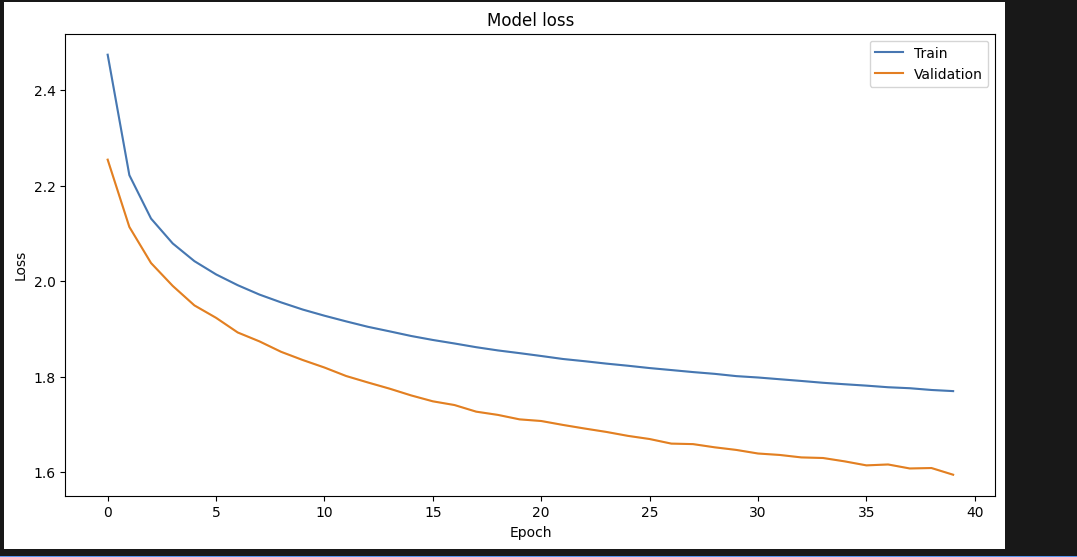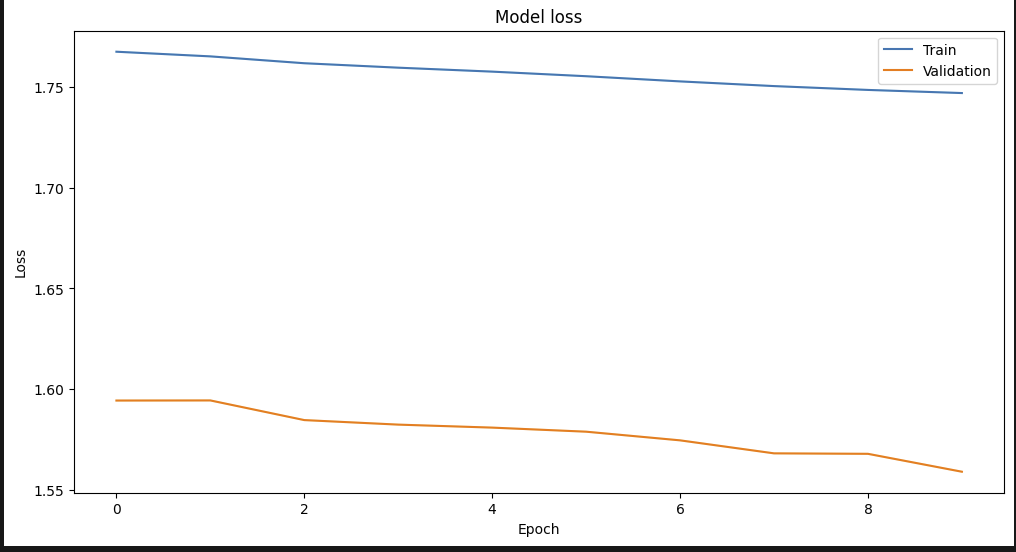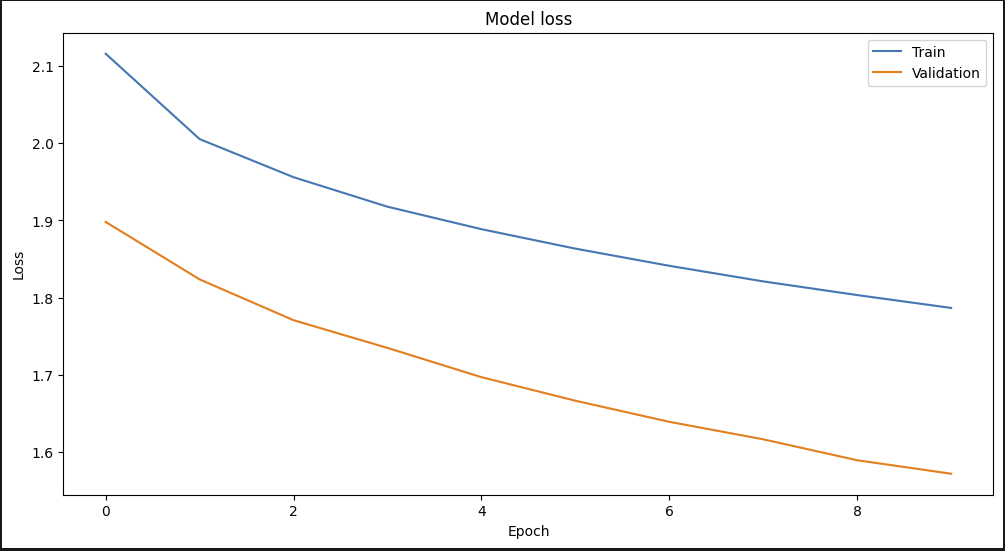 

Nuestros datos se dividían en archivos de acompañamiento y archivos de solos, los primeros dos entrenamientos se hicieron con los datos de acompañamientos y solos y el último se hizo solamente con los archivos de solos porque queríamos orientar el modelo hacia generación de solos más que acompañamientos. Sin embargo fueron importantes los datos de acompañamiento para darle al modelo algo de polifonía, ya que los acompañamientos son acordes y/o arpegios, es decir varias notas al mismo tiempo. Es por eso se ve que la pérdida comienza un poco más arriba de lo que había terminado en el segundo entrenamiento, porque cambió el conjunto de entrenamiento.

# Generación de nuevos tokens #
Ahora cargamos el modelo ya entrenado y mostramos cómo generamos nuevos tokens. Como el modelo no predice acordes, cada vez que genere un nuevo token hay que pasarle la información de los acordes siguientes, esto se hace en la función generate_next_token. Para generar las siguientes alturas, duraciones y desfases tomamos las distribuciones correspondientes que nos devuelve model.predict() y muestreamos cada distribución para producir un índice por cada característica de la nota (altura, duración, desfase). 

In [22]:
learning_rate = 1e-4
#cargar modelo sin optimizador
@tf.keras.utils.register_keras_serializable()

def custom_loss(y_true, y_pred):
    # Segmentar las predicciones
    pitch_pred = y_pred[:, :, :128]
    duration_pred = y_pred[:, :, 128:142]
    offset_pred = y_pred[:, :, 142:]

    # Segmentar las etiquetas verdaderas
    y_pitch = y_true[:, :, :128]
    y_duration = y_true[:, :, 128:142]
    y_offset = y_true[:, :, 142:]

    # Calcular la pérdida categorical crossentropy por cada segmento
    loss_pitch = tf.keras.losses.categorical_crossentropy(y_pitch, pitch_pred)
    loss_duration = tf.keras.losses.categorical_crossentropy(y_duration, duration_pred)
    loss_offset = tf.keras.losses.categorical_crossentropy(y_offset, offset_pred)
    loss_pitch = tf.reduce_mean(loss_pitch, axis = 0)
    loss_duration = tf.reduce_mean(loss_duration, axis = 0)
    loss_offset = tf.reduce_mean(loss_offset, axis = 0)

    # Combinar las pérdidas (promediar o sumar)
    total_loss = (128*loss_pitch + 14*loss_duration + 53*loss_offset)/195  # Sumar las pérdidas
    return total_loss
loaded_model = tf.keras.models.load_model('modeloCORTO-solos.keras', custom_objects={'custom_loss': custom_loss})
optimizer = Adam(learning_rate = learning_rate)
loaded_model.compile(optimizer=optimizer, loss=custom_loss)
def get_next_idx(model,seed):
        #seed es la semilla (B,T,219), una secuencia de notas y acordes
        note = model.predict(seed) #(B,T,195)
        softmax_segments = [note[:,:,:128],note[:,:,128:142],note[:,:,142:]]#[(B,T,128), (B,T,14), (B,T,53)]
        intervals = [(0, 128), (128, 142), (142, 195)] #
        sampled_indices_all = tf.TensorArray(dtype=tf.int64, size=3)
        for i, (softmax_segment, (start, end)) in enumerate(zip(softmax_segments, intervals)):
            S = softmax_segment.shape[-1]
            softmax_segment = softmax_segment[:,-1,:] #(B,S), tomar solo el último paso de tiempo
            #samplear un índice de cada segmento softmax
            sampled_indices = tf.random.categorical(tf.math.log(softmax_segment), num_samples=1)#(B,1)
            #sumar start para que los índices estén en el rango correcto
            sampled_indices = tf.squeeze(sampled_indices, axis=-1)+start #(B,)
            sampled_indices_all = sampled_indices_all.write(i, sampled_indices)
        #volteretas para que la forma sea (B,3)
        sampled_indices_all = sampled_indices_all.stack()
        return tf.transpose(sampled_indices_all)
#funciones para generar
def get_next_note(model, seed):
    indices = get_next_idx(model,seed)
    B = tf.shape(indices)[0]
    n_hot_vectors = tf.TensorArray(dtype=tf.float32, size=B)
    for i in tf.range(B):
        #crea 3 vectores y luego los suma
        n_hot = tf.reduce_sum(tf.one_hot(indices[i], depth=195), axis=0)
        n_hot_vectors = n_hot_vectors.write(i, n_hot)
    return n_hot_vectors.stack() # (B,195)
    
def generate_next_token(model, seed, next_chord):
    # generar siguiente nota con acorde actual y siguiente,
    # next_chords es una lista de tensores tf
    # seed es la semilla (B,T,219), una secuencia de notas y acordes
    #seed y next_chord DEBEN ser tf.float32
    # obtener el siguiente vector n-hot de notas
    next_note = get_next_note(model,seed)  # (B,195)
    B = next_note.shape[0]
    current_chord = seed[:, -1, -12:]# (B,12)
    next_chord = tf.expand_dims(next_chord, axis = 0) #(1,12)
    next_chord = next_chord = tf.tile(next_chord, [B, 1]) #(B,12)
    next_token = tf.concat([next_note,current_chord,next_chord], axis = -1) #(B,219)
    return next_token
def generate_n_tokens(model,seed, next_chords):
    #next_chords debe ser una lista con siguientes acordes
    n = len(next_chords)
    T = seed.shape[1] 
    for i in range(n):
        next_token = generate_next_token(model,seed[:,-T:,:],next_chords[i])#(B,219)
        next_token = tf.expand_dims(next_token, axis = 1) # (B,1,219)
        seed = tf.concat([seed,next_token],axis = 1)
    return seed
#tomar un archivo cualquiera y tokenizarlo para generar a partir de él 
X, bpm = jams_a_vec('/Users/santiagogonzalez/Documents/Programación/proyectoFinalIA/data/annotation-solos/03_Rock3-117-Bb_solo.jams')
#como cuando íbamos a entrenar el modelo, debemos agregar los siguientes acordes a cada token para pasarlos a model.predict()
acordes_sig = X[1:len(X)] #de aquí van a salir los acordes siguientes
X = X[:len(X)-1] 
# num tokens a generar
n = 120
#Aquí se crea la semilla que le vamos a pasar al modelo. Se concatena para agregar info. de acordes siguientes
semilla = [tf.concat([X[i],acordes_sig[i][-12:]],axis = -1) for i in range(len(X))]
#Las semillas deben tener longitud T y ser tf.float32
semilla = tf.cast(tf.stack([semilla[:60]]),dtype = tf.float32)
#Se toman los acordes que subsiguen al acorde del último token en la semilla
como_sigue = [acordes_sig[(60+i)%len(X)][-12:] for i in range(n)]
#acordes siguientes para generación (el modelo no predice acordes)
next_chords = tf.cast(tf.stack(como_sigue),dtype = tf.float32)
tokens = generate_n_tokens(loaded_model,semilla,next_chords)[0]
print(f'60 tokens de semilla + {n} tokens generados = {tokens.shape[0]} tokens')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━

# Pasar de tokens a midi # 
Los resultados se pueden ver y escuchar en el video.

In [23]:
from music21 import stream, note, duration, midi, instrument, tempo
import numpy as np
#función para convertir resultado en MIDI
def tokens2midi(tokens, filename,bpm):
    s = stream.Stream()
    s.insert(0, instrument.ElectricPiano())
    metronome_mark = tempo.MetronomeMark(number=bpm)
    s.insert(0, metronome_mark)
    offsets = [i / 8 for i in range(31)]
    for i in range(1, 23):
        offsets.append(i / 6)
    offsets.sort()
    duraciones = [1 / 8, 1 / 6, 1.5 / 8, 1 / 4, 1 / 3, 1.5 / 4, 1 / 2, 2 / 3, 1.5 / 2, 1, 1.5, 2, 3, 4]
    t_abs = 0
    for token in tokens:
        pitch = token[:128]
        duration_token = token[128:142]
        offset = token[142:]
        pitch_idx = np.where(pitch == 1)[0][0]
        duration_idx = np.where(duration_token == 1)[0][0]
        offset_idx = np.where(offset == 1)[0][0]
        duration_value = duraciones[duration_idx]
        offset_value = offsets[offset_idx]
        n = note.Note(midi=pitch_idx)
        n.duration = duration.Duration(quarterLength=duration_value)
        t_abs += offset_value
        s.insert(t_abs, n)
    # Crear un objeto MIDIFile a partir del stream
    mf = midi.translate.music21ObjectToMidiFile(s)

    # Escribir el archivo MIDI
    mf.open(filename, 'wb')
    mf.write()
    mf.close()

tokens2midi(tokens[60:,:], 'partegenerada.mid',bpm)
tokens2midi(tokens, 'partecompleta.mid',bpm)

# Evaluacion de métricas 
En esta sección se evaluan las métricas de entropias para las ditribuciones de tono, duración y desface. La entropia se calcula con el conteo de frecuencia de valores de cada atributo, normalizado. La primera parte consiste de las métricas para el set de datos de entrenamiento, y la siguiente sección contiene las métricas para los archivos generados.  Se calcula además la divergencia de KL de cada archivo generado con cada archivo del corpus, para comparar las distribuciones. Finalmente se tienen medidas de coherencia armónica y subsecuencia común más larga, que buscan determinar que tanto la melodia generada se adapta al acorde/escala de acompañamiento y en que porcentaje de notas subsecuentes se parecen dos melodias.

In [27]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
def possible_scales_from_vec(vec):
    """
    Find the possible scales for a given pitch vector.

    Args:
        vec (np.ndarray): Pitch vector one hot encoded

    Returns:
        list: of each possible scale vectors
    """
    chord = np.where(vec == 1)[0]
    type_of_chord = chord-chord[0]
    possible_scales = []
    for key in scale_modes.keys():
        if set(type_of_chord) <= set(scale_modes[key]):
            possible_scales.append(key)
    possible_scale_vecs = []
    for scale in possible_scales:
        scale_vec = np.zeros(12)
        scale_idx = scale_modes[scale]
        for idx in scale_idx:
            scale_vec[(chord[0] + idx) % 12] = 1
        possible_scale_vecs.append(scale_vec)
    return possible_scale_vecs
def longest_contiguous_common_subsequence(A, B):
    """Find the longest contiguous common subsequence between two sequences.

    Args:
        A (list): First sequence.
        B (list): Second sequence.

    Returns:
        list: Longest contiguous common subsequence.
    """
    m = len(A)
    n = len(B)
    
    # Initialize DP table
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    
    # Variables to keep track of the maximum length and ending position
    max_len = 0
    end_pos = 0
    
    # Fill DP table
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if A[i - 1] == B[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
                if dp[i][j] > max_len:
                    max_len = dp[i][j]
                    end_pos = i - 1  # or j - 1, both are same in case of contiguous subsequence
            else:
                dp[i][j] = 0
    
    # If max_len is 0, no contiguous common subsequence exists
    if max_len == 0:
        return None
    
    # Retrieve longest contiguous common subsequence
    result = A[end_pos - max_len + 1:end_pos + 1]
    return result

def calculate_entropies(file_name,show_plot=False,save_plot=None,generated=False):
    """
    Calculate the entropy of pitch, duration, and offset vectors from a JAMS file.
    Args:
        file_name (string): Name of the JAMS file.
        show_plot (bool, optional): Whether to show the plot of the histogram or not. Defaults to False.
        save_plot (string, optional): name of file to save the plot. Defaults to None.
        generated (bool, optional): wheteher the files are generated or not. Defaults to False.

    Returns:
        tuple: Entropy of  vectors.
    """
    if generated:
        gen_np = np.load('./data/generated/'+file_name)
        pitch_vecs = gen_np[:,0:128]
        dur_vecs = gen_np[:,128:142]
        offset_vecs = gen_np[:,142:195]

    # convertir a one hot
    else:
        X , _, _ = jams_a_vec('./data/annotation/'+file_name)
        pitch_vecs = np.array([x[:128] for x in X])
        dur_vecs = np.array([x[128:142] for x in X])
        offset_vecs = np.array([x[142:195] for x in X])

    #count notes 
    # print(len(pitch_vecs[0]), len(dur_vecs[0]), len(offset_vecs[0]))
    count_pitch  = np.array(pitch_vecs).sum(axis=0)
    
    #calculate entropy pitch
    count_pitch_normalized = count_pitch/sum(count_pitch)
    entropy_pitch = -sum(count_pitch_normalized*np.log2(count_pitch_normalized,where=count_pitch_normalized!=0,out=np.zeros_like(count_pitch_normalized)))
    #lo mismo para la duración
    count_dur  = np.array(dur_vecs).sum(axis=0)
    count_dur_normalized = count_dur/sum(count_dur)
    entropy_dur = -sum(count_dur_normalized*np.log2(count_dur_normalized,where=count_dur_normalized!=0,out=np.zeros_like(count_dur_normalized)))
    # lo mismo para el offset
    count_offset  = np.array(offset_vecs).sum(axis=0)
    count_offset_normalized = count_offset/sum(count_offset)
    entropy_offset = -sum(count_offset_normalized*np.log2(count_offset_normalized,where=count_offset_normalized!=0,out=np.zeros_like(count_offset_normalized)))
    if show_plot or save_plot:
        fig, axs = plt.subplots(3, 1, figsize=(8, 10))
        axs[0].bar(list(range(1,len(count_pitch)+1)), count_pitch)
        axs[0].set_xlabel('Note')
        axs[1].bar(list(range(len(count_dur))), count_dur)
        axs[1].set_xlabel('Duration')
        axs[2].bar(list(range(len(count_offset))), count_offset)
        axs[2].set_xlabel('Offset')
        fig.text(0.06, 0.5, 'Counts', ha='center', va='center', rotation='vertical')
        if save_plot:
            plt.savefig(save_plot)
        if show_plot:
            plt.show()
        else:
            plt.close()
    return entropy_pitch,entropy_dur,entropy_offset

def midi_to_name(vect):
    """ Convert a MIDI vector to a note vector.

    Args:
        vect (np.ndarray):one hot encoded vector

    Returns:
       array lenght 12: note vector that counts any note in the octave
    """
    octava_separada = [vect[i:i +12] for i in range(0, len(vect),12)]
    octava_separada[-1] = np.insert(octava_separada[-1],-1,[0,0,0,0])[:12]
    note_any_octave = np.array(np.ufunc.reduce(np.logical_or, octava_separada)).astype(int)
    return note_any_octave

#check harmonic coherence
def harmonic_coherence(pitch_vecs,possible_scales):
    """
    Calculate the harmonic coherence of a sequence of pitch vectors

    Args:
        pitch_vecs (np.ndarray): one hot encoded pitch vectors
        possible_scales (list): list of possible scales for each chord

    Returns:
        float: percentage of notes that are in the possible scales
    """
    matches = []
    for i in range(len(pitch_vecs)):
        note = midi_to_name(pitch_vecs[i])
        this_note_possible_scales = np.array(possible_scales[i])
        match = np.dot(this_note_possible_scales,note).sum()/len(this_note_possible_scales)
        matches.append(match)
    percentage = np.array(matches).mean()
    return percentage
def relative_distances(pitch_vecs):
    """
    Calculate the relative distances between notes in a sequence of pitch vectors

    Args:
        pitch_vecs (np.ndarray): one hot encoded pitch vectors

    Returns:
        np.ndarray: same lenght as pitch_vecs with the relative distances between notes, last note has distance 0
    """
    distances = []
    for i in range(0,len(pitch_vecs)-1):
        note_1 = pitch_vecs[i]
        note_2 = pitch_vecs[i+1]
        distance = abs(np.where(note_1==1)[0]  - np.where(note_2==1)[0])
        distances.append(distance[0])
    distances.append(0)
    return distances
def common_subsequence(jams1,jams2):
    """
    Calculate the longest contiguous common subsequence between two sequences of notes

    Args:
        jams1 (tuple): pitch vectors, duration vectors, offset vectors, chord vectors, possible scales of the first JAMS file
        jams2 (tuple): pitch vectors, duration vectors, offset vectors, chord vectors, possible scales of the second JAMS file

    Returns:
        int: length of the longest contiguous common subsequence
    """
    pitch_vecs1, dur_vecs1, _,_,_= jams1
    pitch_vecs2, dur_vecs2, _,_,_= jams2
    relative_distances1 = relative_distances(pitch_vecs1)
    relative_distances2 = relative_distances(pitch_vecs2)
    array1 = [[relative_distances1[i],dur_vecs1[i].astype(int).tolist()] for i in range(len(relative_distances1))]
    array2 = [[relative_distances2[i],dur_vecs2[i].astype(int).tolist()] for i in range(len(relative_distances2))]
    if longest_contiguous_common_subsequence(array1,array2):
        return len(longest_contiguous_common_subsequence(array1,array2))
    else:
        return 0


360

In [52]:
#make a list of all files of original data
files = [file for file in os.listdir('./data/annotation') if file.endswith('.jams')]
len(files)

360

In [ ]:
#transform all jam files to vec
all_file_list = []
for file in files:
    X, _ ,possible_scales = jams_a_vec('./data/annotation/'+file)
    pitch_vecs = np.array([x[:128] for x in X])
    dur_vecs = np.array([x[128:142] for x in X])
    offset_vecs = np.array([x[142:195] for x in X])
    chord_vecs = np.array([x[-12:] for x in X])
    all_file_list.append([pitch_vecs, dur_vecs, offset_vecs, chord_vecs,possible_scales])
#save all files
import pickle
with open('./data/metrics/all_files.pkl', 'wb') as f:
    pickle.dump(all_file_list, f)

In [29]:
#entropies for all original data files
data = [ ]
for file in files:
    pitch,duration,offset = calculate_entropies(file,show_plot=False,save_plot='./data/metrics/plots/'+file[:-5]+'.png')
    data.append({'file': file, 'entropy_pitch': pitch, 'entropy_duration': duration, 'entropy_offset': offset})
    
entropies = pd.DataFrame(data)

entropies.to_csv('./data/metrics/entropies.csv', index=False)

print(entropies[['entropy_pitch', 'entropy_duration', 'entropy_offset']].mean())

entropy_pitch       3.556122
entropy_duration    2.799534
entropy_offset      2.895642
dtype: float64


In [30]:
#print the standart deviations of entropies
entropies = pd.read_csv('./data/metrics/entropies.csv')
#calculate std
print(entropies[['entropy_pitch', 'entropy_duration', 'entropy_offset']].std())

entropy_pitch       0.439438
entropy_duration    0.308698
entropy_offset      0.603527
dtype: float64


In [32]:
#harmonic coherence of all original data files, print mean
harmonic_coherences = []
for file in files:
    X, bpm, possible_scales = jams_a_vec('./data/annotation/'+file)
    pitch_vecs = np.array([x[:128] for x in X])
    harmonic_coherences.append(harmonic_coherence(pitch_vecs,possible_scales))
hc = pd.DataFrame({'file': files, 'harmonic_coherence': harmonic_coherences})
hc.to_csv('./data/metrics/harmonic_coherence.csv', index=False)
print(hc['harmonic_coherence'].mean())

0.864992465757785


In [33]:
# standard deviation of harmonic coherence of all original data files
print(hc['harmonic_coherence'].std())

0.08184772531588434


In [37]:
#common subsequence of all original data files, print mean
matrix = np.zeros((len(all_file_list),len(all_file_list)))
for i in range(len(all_file_list)):
    matrix[i,i] = 0
    for j in range(i+1,len(all_file_list)):
        matrix[i,j] = common_subsequence(all_file_list[i],all_file_list[j])
        matrix[j,i] = matrix[i,j]
np.save('./data/metrics/common_subsequence.npy', matrix)

In [40]:
#average common subsequence  mean and std per file
average_common_subsequence = matrix.mean(axis=1)
acs = pd.DataFrame({'file': files, 'average_common_subsequence': average_common_subsequence,'std': matrix.std(axis=1)})
acs.to_csv('./data/metrics/average_common_subsequence.csv', index=False)

In [41]:
acs.sample(5)

,file,average_common_subsequence,std
193,03_Funk1-114-Ab_solo.jams,1.938889,0.742847
328,05_Jazz2-110-Bb_comp.jams,1.666667,0.760117
113,01_SS2-107-Ab_solo.jams,2.047222,0.796167
199,03_Funk2-119-G_solo.jams,2.030556,0.559424
74,01_Funk1-97-C_comp.jams,1.830556,0.860658


In [43]:
# mean of all means, and std of all means
print(acs['average_common_subsequence'].mean())
print(acs['average_common_subsequence'].std())


1.884151234567901
0.21893433874155213


Ahora se hace el mismo ejercicio con los datos generados

In [44]:
#list all generated files
generated_files = [file for file in os.listdir('./data/generated') if file.endswith('.npy')]
len(generated_files)

100

In [45]:
#calculate entropies for all generated files
data = []
for file in generated_files:
    pitch,duration,offset=calculate_entropies(file,show_plot=False,save_plot='./data/metrics/generated/plots/'+file[:-4]+'.png',generated=True)
    data.append({'file': file, 'entropy_pitch': pitch, 'entropy_duration': duration, 'entropy_offset': offset})
data = pd.DataFrame(data)
data.to_csv('./data/metrics/generated/entropies.csv', index=False)
print(data[['entropy_pitch', 'entropy_duration', 'entropy_offset']].mean())
print(data[['entropy_pitch', 'entropy_duration', 'entropy_offset']].std())


entropy_pitch       3.278294
entropy_duration    2.867671
entropy_offset      3.129005
dtype: float64
entropy_pitch       0.436090
entropy_duration    0.242717
entropy_offset      0.529673
dtype: float64


In [47]:
# calculate harmonic coherence for all generated files and print mean and standard deviation
harmonic_coherences = []
for file in generated_files:
    gen_np = np.load('./data/generated/'+file)
    pitch_vecs, dur_vecs, offset_vecs, chord_vecs,next_chord_vec = gen_np[:,:128],gen_np[:,128:142],gen_np[:,142:195],gen_np[:,195:207],gen_np[:,207:]
    possible_scales =[possible_scales_from_vec(vec) for vec in chord_vecs]
    harmonic_coherences.append(harmonic_coherence(pitch_vecs,possible_scales))
    hc = pd.DataFrame({'file': file, 'harmonic_coherence': harmonic_coherences})
hc.to_csv('./data/metrics/harmonic_coherence.csv', index=False)
print(hc['harmonic_coherence'].mean())
print(hc['harmonic_coherence'].std())

0.8615361111111111
0.053794238313759735


In [ ]:
# common subsecuence for all generated files
matrix = np.zeros((len(generated_files),len(all_file_list)))
for i in range(len(generated_files)):
    file_1 = np.load('./data/generated/'+generated_files[i])
    for j in range(len(all_file_list)):
        file_2 = all_file_list[j]
        matrix[i,j] = common_subsequence([file_1[:,:128],file_1[:,128:142],file_1[:,142:195],file_1[:,195:207],file_1[:,207:]],file_2)
np.save('./data/metrics/generated/common_subsequence.npy', matrix)

In [49]:
# average common subsequence of all means per file
print(matrix.mean(axis=1).mean())
print(matrix.mean(axis=1).std())

1.9695277777777775
0.10623571436279251


In [50]:
# calculate the kl divergence
def kl_divergence(P, Q):
    epsilon = 0.00001
    # Convert inputs to numpy arrays
    P = np.asarray(P, dtype=np.float64)
    Q = np.asarray(Q, dtype=np.float64)
    P = P+epsilon
    Q = Q+epsilon
    # Compute the KL divergence
    kl_div = np.sum(np.where(P != 0, P * np.log2(P / Q), 0))
    
    return kl_div
kl_divergences_pitch = np.zeros((len(generated_files),len(all_file_list)))
kl_divergences_dur = np.zeros((len(generated_files),len(all_file_list)))
kl_divergences_offset = np.zeros((len(generated_files),len(all_file_list)))

for i in range(len(generated_files)):
    gen_np = np.load('./data/generated/'+generated_files[i])
    pitch_vecs, dur_vecs, offset_vecs, _,__dict__ = gen_np[:,:128],gen_np[:,128:142],gen_np[:,142:195],gen_np[:,195:207],gen_np[:,207:]
    pitch_vecs_counts_normalized = np.array(pitch_vecs).sum(axis=0)/sum(np.array(pitch_vecs).sum(axis=0))
    dur_vecs_counts_normalized = np.array(dur_vecs).sum(axis=0)/sum(np.array(dur_vecs).sum(axis=0))
    offset_vecs_counts_normalized = np.array(offset_vecs).sum(axis=0)/sum(np.array(offset_vecs).sum(axis=0))
    for j in range(len(all_file_list)):
        pitch_vecs_org, dur_vecs_org, offset_vecs_org, _,_ = all_file_list[j]
        pitch_vecs_org_counts_normalized = np.array(pitch_vecs_org).sum(axis=0)/sum(np.array(pitch_vecs_org).sum(axis=0))
        dur_vecs_org_counts_normalized = np.array(dur_vecs_org).sum(axis=0)/sum(np.array(dur_vecs_org).sum(axis=0))
        offset_vecs_org_counts_normalized = np.array(offset_vecs_org).sum(axis=0)/sum(np.array(offset_vecs_org).sum(axis=0))
        kl_divergences_pitch[i,j] = kl_divergence(pitch_vecs_org_counts_normalized,pitch_vecs_counts_normalized)
        kl_divergences_dur[i,j] = kl_divergence(dur_vecs_org_counts_normalized,dur_vecs_counts_normalized)
        kl_divergences_offset[i,j] = kl_divergence(offset_vecs_org_counts_normalized,offset_vecs_counts_normalized)
# average kl divergence of the average kl divergence per file        
print(kl_divergences_pitch.mean(axis=1).mean())
print(kl_divergences_dur.mean(axis=1).mean())
print(kl_divergences_offset.mean(axis=1).mean())
print(kl_divergences_pitch.mean(axis=1).std())
print(kl_divergences_dur.mean(axis=1).std())
print(kl_divergences_offset.mean(axis=1).std())


6.240699024927538
1.3822571816779348
3.3342948217464157
1.3702818670695018
0.7182674569193387
1.3433411903153627


In [51]:
#save results
np.save('./data/metrics/generated/kl_divergences_pitch.npy', kl_divergences_pitch)
np.save('./data/metrics/generated/kl_divergences_dur.npy', kl_divergences_dur)
np.save('./data/metrics/generated/kl_divergences_offset.npy', kl_divergences_offset)